In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("Titanic-Dataset.csv", index_col=None)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.shape

(891, 12)

In [4]:
from sklearn.model_selection import train_test_split

X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
#now we will work with a copy of the training data

df_copy = X_train.copy()

In [6]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 331 to 102
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Pclass       712 non-null    int64  
 2   Name         712 non-null    object 
 3   Sex          712 non-null    object 
 4   Age          572 non-null    float64
 5   SibSp        712 non-null    int64  
 6   Parch        712 non-null    int64  
 7   Ticket       712 non-null    object 
 8   Fare         712 non-null    float64
 9   Cabin        159 non-null    object 
 10  Embarked     710 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 66.8+ KB


In [7]:
df_copy.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,572.000000,712.000000,712.000000,712.000000
mean,448.234551,2.330056,29.498846,0.553371,0.379213,32.586276
std,256.731423,0.824584,14.500059,1.176404,0.791669,51.969529
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,224.750000,2.000000,21.000000,0.000000,0.000000,7.925000
50%,453.500000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,673.500000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
df_copy['Sex'].value_counts()

male      467
female    245
Name: Sex, dtype: int64

In [9]:
df_copy['Embarked'].value_counts()

S    525
C    125
Q     60
Name: Embarked, dtype: int64

In [10]:
#Gender of each passenger and boarding group is not well represented. Possibility of stratified sampling. Age has decimal values. Convert to whole number. Name and Ticket columns are not needed for training. Remove columns.

#so the data should be cleaned

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

# Transformer to fill in the `Age` column and convert it to an integer
class FillAgeAndRound(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.median_age = X['Age'].median()
        return self
    
    def transform(self, X, y=None):
        X['Age'] = X['Age'].fillna(self.median_age).round().astype(int)
        return X

# Transformer to remove the `Cabin` column
class DropCabin(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop('Cabin', axis=1)
    
# Transformer to remove the `Name` column
class DropName(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop('Name', axis=1)
    
# Transformer to remove the `Ticket` column
class DropTicket(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop('Ticket', axis=1)

# Transformer to remove rows with NaN values in `Embarked`.
class DropNanEmbarked(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X.dropna(subset=['Embarked'], inplace=True)
        return X

# Transformer to apply the `OrdinalEncoder`.
class EncodeColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoder = OrdinalEncoder()
    
    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self
    
    def transform(self, X, y=None):
        X[self.columns] = self.encoder.transform(X[self.columns])
        return X

In [12]:
# Pipeline construction
preprocessing_pipeline = Pipeline([
    ('fill_age', FillAgeAndRound()),
    ('drop_cabin', DropCabin()),
    ('drop_name', DropName()),
    ('drop_ticket', DropTicket()),
    ('drop_nan_embarked', DropNanEmbarked()),
    ('encode_columns', EncodeColumns(columns=['Sex', 'Embarked']))
])

In [14]:
train_transformed = preprocessing_pipeline.fit_transform(X_train.copy())
test_transformed = preprocessing_pipeline.transform(X_test.copy())

y_train = y_train[train_transformed.index]
y_test = y_test[test_transformed.index]

In [15]:
train_transformed.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
331,332,1,1.0,46,0,0,28.5000,2.0
733,734,2,1.0,23,0,0,13.0000,2.0
382,383,3,1.0,32,0,0,7.9250,2.0
704,705,3,1.0,26,1,0,7.8542,2.0
813,814,3,0.0,6,4,2,31.2750,2.0


In [16]:
#Model selection and training

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

sgd_clf = SGDClassifier(random_state=42)
knn_clf = KNeighborsClassifier()
tree_clf = DecisionTreeClassifier(random_state=42)
forest_clf = RandomForestClassifier(random_state=42)


In [17]:
from sklearn.model_selection import cross_validate

model_list = [sgd_clf, knn_clf, tree_clf, forest_clf]
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']
model_names = ["SGD", "KNN", "Decision Tree", "Random Forest"]

for model, name in zip(model_list, model_names):
    scores = cross_validate(model, train_transformed, y_train, cv=5, scoring=scoring_metrics)
    print(f"{name}:\n"
          f"Accuracy: {scores['test_accuracy'].mean():.2f} (+/- {scores['test_accuracy'].std():.2f})\n"
          f"Precision: {scores['test_precision'].mean():.2f} (+/- {scores['test_precision'].std():.2f})\n"
          f"Recall: {scores['test_recall'].mean():.2f} (+/- {scores['test_recall'].std():.2f})\n"
          f"F1-score: {scores['test_f1'].mean():.2f} (+/- {scores['test_f1'].std():.2f})\n")

SGD:
Accuracy: 0.45 (+/- 0.09)
Precision: 0.36 (+/- 0.05)
Recall: 0.77 (+/- 0.38)
F1-score: 0.44 (+/- 0.20)

KNN:
Accuracy: 0.62 (+/- 0.03)
Precision: 0.49 (+/- 0.07)
Recall: 0.35 (+/- 0.06)
F1-score: 0.41 (+/- 0.06)

Decision Tree:
Accuracy: 0.74 (+/- 0.02)
Precision: 0.65 (+/- 0.03)
Recall: 0.67 (+/- 0.05)
F1-score: 0.66 (+/- 0.03)

Random Forest:
Accuracy: 0.81 (+/- 0.02)
Precision: 0.80 (+/- 0.06)
Recall: 0.68 (+/- 0.03)
F1-score: 0.73 (+/- 0.02)



In [ ]:
#from the above analysis Random Forest in the best model for this. 

In [18]:
# Cross-validation for hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

forest_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(forest_clf, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(train_transformed, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30, 40],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 150, 200]},
             return_train_score=True, scoring='accuracy')

In [19]:
best_forest_clf = grid_search.best_estimator_
print(best_forest_clf)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=10,
                       random_state=42)


In [20]:
y_pred = best_forest_clf.predict(test_transformed)

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.8044692737430168
Precision: 0.8
Recall: 0.7027027027027027
F1 Score: 0.7482014388489208


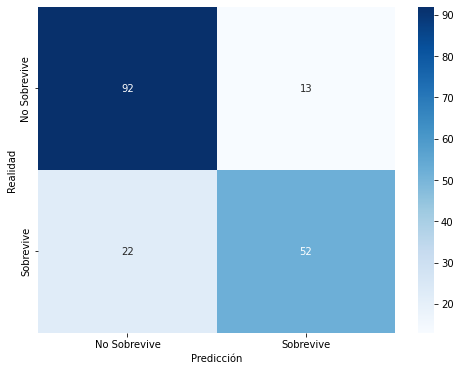

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Sobrevive', 'Sobrevive'], yticklabels=['No Sobrevive', 'Sobrevive'])
plt.ylabel('Realidad')
plt.xlabel('Predicción')
plt.show()